### Overview

Input 1 DICOM volumn --> RetinaNet --> VGG --> Grad-CAM visualization

If you got an error when importing the pydicom package:
Step 1: run the following lines:
- !pip uninstall numpy
- !pip install numpy

Step 2: enter 'y' in the prompt

Step 3: delete the 2 commands in step 1

Step 4: restart the runtime and run all


In [ ]:
# !pip uninstall numpy
# !pip install numpy


In [ ]:

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q tqdm 
!pip install -q imgaug
!pip install -q pickle5

#imports needed for dbtex function
print('---dbtex installs---')
!pip install -q pylibjpeg  #for dbtex
!pip install -q python-gdcm
!pip install -q pylibjpeg-libjpeg 
!pip install -q pylibjpeg-openjpeg
!pip install -q Pillow



---dbtex installs---


In [ ]:
import sys
import os

import pandas as pd
import random
from glob import glob
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
from pathlib import Path
import six
import csv
import logging
import math
import statistics
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from PIL import Image 
import scipy.misc
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, recall_score, f1_score, precision_score, confusion_matrix, classification_report
from datetime import datetime
from scipy.spatial import distance
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torch.optim as optim

from typing import AnyStr, BinaryIO, Optional, Union
from skimage.exposure import rescale_intensity

import pydicom as dicom
import pickle5 as pickle; #generic storage of image array
import PIL
import pylibjpeg

from torchvision.transforms import ToTensor, Lambda
#show model design parameters with torchsummary
import torchsummary
from torchsummary import summary
from torch import FloatTensor
from torch import tensor

# Mount the google drive so that we can access the data stored in the drive
from google.colab import drive
drive.mount('/content/gdrive')

#
# SET LOCAL IMPORT DIRECTORY FOR .PY FILES
#
sys.path.append('/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES')
!ls '/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES'


from VGG16 import VGG16


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
create_augmented_data.py  randomize_patches.py	vgg_cam.py
CustomImageDataset.py	  TestImageDataset.py	VGG_Classify.py
__pycache__		  VGG16.py


In [ ]:
### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-51892e15-f0af-06ed-fcf3-e85e3dfc2917)
Tue Jun  8 02:42:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   1929MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

### All functions

In [ ]:
# Store all the 2D slices, class labels, case IDs, and 2D slice index
# These things are stored in a dictionary for each slice

def create_dataset_from_pickle(img_array, img_name):
  dataset = []

  # Since we won't know which slice contains potential cancer, we need to go through all slices
  for box_slice_index in range(img_array.shape[0]):
    img_slice = img_array[box_slice_index, :, :]
    # Normalize the image (min max norm)
    img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
    img_slice = padding(img_slice, 2457, 1996)
    # Convert into a 3 channel image
    img_slice = np.stack((img_slice,)*3, axis = 0)
    data = {}
    data['img'] = img_slice
    data['class'] = (img_name.split('_')[5]).split('.')[0]
    data['slice_index'] = box_slice_index
    data['PatientID'] = (img_name.split('_')[2]).split('/')[1]
    data['StudyUID'] = img_name.split('_')[3]
    data['View'] = img_name.split('_')[4]

    dataset.append(data)

  return dataset

# A helper function to do zero padding on images so that we have the same size for all images.
def padding(array, xx, yy):

  h = array.shape[0]
  w = array.shape[1]

  a = (xx - h) // 2
  aa = xx - a - h

  b = (yy - w) // 2
  bb = yy - b - w

  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def run_retinanet(img_data, img_name):
  # Load the trained model weights 
  retinanet = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 2, pretrained = False, pretrained_backbone = True) 
  checkpoint = torch.load('/content/gdrive/Shareddrives/DBTdata/code/RetinaNet/model_20_epochs.pth')
  retinanet.load_state_dict(checkpoint['net'])
  retinanet.to(device = dev)
  retinanet.eval()

  num_top_boxes_to_save = 3
  save_predictions = []

  to_be_predicted = create_dataset_from_pickle(img_data, img_name)

  # Loop through each slice in the 3D volume
  for slice_index in range(len(to_be_predicted)):

    # Convert the image array to tensor 
    image = torch.from_numpy(to_be_predicted[slice_index]['img'].astype(np.float32))
    image = image.to(device = dev) # Put it on the GPU
    image = [image]

    # The outputs consist of 300 predicted boxes, their predicted class labels, and confidence scores.
    # They're already ranked in a decreasing order according to the confidence scores
    outputs = retinanet.forward(image)
    outputs = [{k: v.detach().cpu().numpy() for k, v in t.items()} for t in outputs] # Convert tensors to numpy

    # Save the top 3 boxes with the highest confidence score
    for prediction_index in range(num_top_boxes_to_save):
      one_prediction = {}
      one_prediction['Slice'] = to_be_predicted[slice_index]['slice_index']
      one_prediction['Patient'] = to_be_predicted[slice_index]['PatientID']
      one_prediction['StudyUID'] = to_be_predicted[slice_index]['StudyUID']
      one_prediction['View'] = to_be_predicted[slice_index]['View']
      one_prediction['Slice'] = to_be_predicted[slice_index]['slice_index']
      one_prediction['GTClass'] = to_be_predicted[slice_index]['class']
      pred_box = outputs[0]['boxes'][prediction_index]
      # For the predicted box, change from (x1, y1, x2, y2) to (x, y, w, h) 
      pred_box[2] -= pred_box[0]
      pred_box[3] -= pred_box[1]
      one_prediction['pred_X'] = pred_box[0]
      one_prediction['pred_Y'] = pred_box[1]
      one_prediction['pred_width'] = pred_box[2]
      one_prediction['pred_height'] = pred_box[3]
      one_prediction['confidence'] = outputs[0]['scores'][prediction_index]
      save_predictions.append(one_prediction)
    
  df_save_predictions = pd.DataFrame(save_predictions)
  return df_save_predictions

# Some boxes are exactly the same but with a different confidence threshold. 
# That's because the confidence is for both the box prediction and the classification within the retinanet. So it's not an error. 
# This function post-processes the output dataframe, so that the same boxes won't appear twice.
def post_process_outputs(df):
  to_be_deleted = []
  for i in range(len(df) - 1):
      if df['pred_X'][i] == df['pred_X'][i + 1] and df['pred_Y'][i] == df['pred_Y'][i + 1] and df['pred_width'][i] == df['pred_width'][i + 1] and df['pred_height'][i] == df['pred_height'][i + 1]:
        to_be_deleted.append(i)
  df = df.drop(to_be_deleted)
  df = df.reset_index(drop = True)
  # Only keep the boxes that have confidence above the (mean + 1 standard deviation) confidence of all predicted boxes.
  threshold = np.mean(df['confidence']) + np.std(df['confidence'])
  boxes_with_low_confidence = np.where(df['confidence'] < threshold)[0]
  df = df.drop(boxes_with_low_confidence)
  df = df.reset_index(drop = True)
  return df

# Helper function to get rid of the cases that are the same as the ones in the old training set.
# def prune_overlapping_cases():
#   overlaps = []
#   for i in range(len(df_new_dataset_labels)):
#     for j in range(len(df_old_dataset_labels)):
#       if df_old_dataset_labels['PatientID'][j] == df_new_dataset_labels['PatientID'][i] and df_old_dataset_labels['StudyUID'][j] == df_new_dataset_labels['StudyUID'][i] and df_old_dataset_labels['View'][j] == df_new_dataset_labels['View'][i]:
#           overlaps.append(i)

#   df_new_dataset_labels_pruned = df_new_dataset_labels.drop(overlaps)
#   df_new_dataset_labels_pruned = df_new_dataset_labels_pruned.reset_index(drop = True)
#   df_new_dataset_labels_pruned
#   return df_new_dataset_labels_pruned

# Randomly subsample a user specified number of cases per class. 
# Class can be normal, benign, cancer.
def randomly_subsample_dataset(num_cases_per_class):
  img_arrays_path = '/content/gdrive/Shareddrives/DBTdata/DBT_DATA/IMG_ARRAYS/'
  img_names = glob(os.path.join(img_arrays_path, '*.pickle'))
  img_names_normal = []
  img_names_cancer = []
  img_names_benign = []
  img_names_total = []

  for i in range(len(img_names)):
    if 'Normal' in os.path.basename(img_names[i]):
      img_names_normal.append(img_names[i])
    elif 'Benign' in os.path.basename(img_names[i]):
      img_names_benign.append(img_names[i])
    elif 'Cancer' in os.path.basename(img_names[i]):
      img_names_cancer.append(img_names[i])

  random.seed(99)
  random.shuffle(img_names_normal)
  random.shuffle(img_names_benign)
  random.shuffle(img_names_cancer)
  img_names_total.extend(img_names_normal[0:num_cases_per_class])
  img_names_total.extend(img_names_benign[0:num_cases_per_class])
  img_names_total.extend(img_names_cancer[0:num_cases_per_class])
  return img_names_total

def run_VGG(img_data, df_retinanet_outputs_processed):
  sys.path.append('/content/gdrive/Shareddrives/DBTdata/code/GENERAL_FUNCTIONS/DBT_PY_FILES')
  from TestImageDataset import TestImageDataset
  from VGG_Classify import VGG_Classify

  VGG_model_dir = '/content/gdrive/Shareddrives/DBTdata/code/VGG_MODELS'
  VGG_model_number = 99

  if (VGG_model_number == 1):
      model_test = 'vgg16_best_accuracy_93_EPOCH_96_0.04582521319389343'
  elif (VGG_model_number == 2):
      model_test = 'vgg16_best_accuracy_99_EPOCH_94_0.00040225533302873373'
  else:
      model_test = 'vgg16_best_accuracy_99_EPOCH_73_0.00033' #full augmentation


  final_model = os.path.join(VGG_model_dir,model_test)

  #
  # PROCESS RETINANET BOXES
  #
  numslices, numrows, numcols = np.shape(img_data) #find limits of volume
  predictions = []
  probabilities = []
  for i in range(len(df_retinanet_outputs_processed)):
      if (df_retinanet_outputs_processed['Slice'][i] == 0): #skip slice 0, for now (VGG needs slice-1)
          print('Slice is too low')
          predictions.append(np.nan)
          continue
      if (df_retinanet_outputs_processed['Slice'][i] == numslices-1): #due to 0 ordering
          print('At upper edge of volume')
          predictions.append(np.nan)
          continue
      box_info = []
      box_info.append('unknownFileName')
      box_info.append(df_retinanet_outputs_processed['Slice'][i]) #slice
      box_info.append(int(df_retinanet_outputs_processed['pred_Y'][i]))#row corner
      box_info.append(int(df_retinanet_outputs_processed['pred_height'][i])) #row height
      box_info.append(int(df_retinanet_outputs_processed['pred_X'][i])) #col corner
      box_info.append(int(df_retinanet_outputs_processed['pred_width'][i])) #col width
      #Use the current box information as area for VGG
      prediction, probability = VGG_Classify(img_data, box_info,final_model)
      predictions.append(prediction)
      probabilities.append(probability)
      print('----Predicted class number is ', prediction)
  
  # If 1 box were predicted as cancer, then this entire case is cancer (denoted as 1)
  if predictions.count(1) >= 1:
    predicted_labels_this_case = 1
  else:
    predicted_labels_this_case = 0

  return predicted_labels_this_case, predictions, probabilities


### Run code from here

In [ ]:
num_cases_per_class = 10
img_names_normal_benign_cancer = randomly_subsample_dataset(num_cases_per_class)

In [ ]:
# Loop through each DICOM file and make predictions
output_path = '/content/gdrive/Shareddrives/DBTdata/model_final_output/from_DBTChallenge_training_set/'
predicted_labels = []
for i in range(len(img_names_normal_benign_cancer)):
  print('Predicting: ', img_names_normal_benign_cancer[i])
  img_data = pickle.load(open(img_names_normal_benign_cancer[i], "rb" ))

  # Run the RetinaNet model and get predicted bounding boxes as output
  print('Detection module...')
  df_retinanet_outputs = run_retinanet(img_data, img_names_normal_benign_cancer[i])
  df_retinanet_outputs_processed = post_process_outputs(df_retinanet_outputs)
  print('Number of RetinaNet predicted boxes: ', len(df_retinanet_outputs_processed))
  print('Classification module...')
  predicted_labels_this_case, predicted_classes_all_boxes, predicted_probabilities_all_boxes = run_VGG(img_data, df_retinanet_outputs_processed)

  # Save the predicted labels and their corresponding boxes in a dataframe.
  df_retinanet_outputs_processed['pred_class'] = predicted_classes_all_boxes
  df_retinanet_outputs_processed['pred_class'] = df_retinanet_outputs_processed['pred_class'].map({0: 'NonCancer', 1: 'Cancer'})
  filename = os.path.basename(img_names_normal_benign_cancer[i]).split('.')[0]
  df_retinanet_outputs_processed.to_csv(output_path + filename + '.csv', index = False)

  print('Predicted label for this case: ', predicted_labels_this_case)
  predicted_labels.append(predicted_labels_this_case)

Predicting:  /content/gdrive/Shareddrives/DBTdata/DBT_DATA/IMG_ARRAYS/DBT-P02872_DBT-S02928_rcc_Normal.pickle
Detection module...
Number of RetinaNet predicted boxes:  18
Classification module...
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
----Predicted class number is  0
Predicted label for this case:  0
Predicting:  /content/gdrive/Shareddrives/DBTdata/DBT_DATA/IMG_ARRAYS/DBT-P03281_DBT-S05018_rcc_Normal.pickle
Detection module...
Number of RetinaNet predicted boxes:  20
Class

In [ ]:
df_retinanet_outputs_processed

,Slice,Patient,StudyUID,View,GTClass,pred_X,pred_Y,pred_width,pred_height,confidence,pred_class
0,30,DBT-P04090,DBT-S01718,rcc,Cancer,1190.767700,914.788757,252.694946,258.421814,0.239296,NonCancer
1,31,DBT-P04090,DBT-S01718,rcc,Cancer,1180.993408,921.530640,255.568726,258.712891,0.256885,NonCancer
2,40,DBT-P04090,DBT-S01718,rcc,Cancer,1744.352173,865.218872,102.522705,108.770691,0.322122,NonCancer
3,40,DBT-P04090,DBT-S01718,rcc,Cancer,1731.376587,858.484680,95.109009,84.269226,0.267063,NonCancer
4,41,DBT-P04090,DBT-S01718,rcc,Cancer,1743.698242,854.552917,104.162598,111.499146,0.295303,NonCancer
5,41,DBT-P04090,DBT-S01718,rcc,Cancer,1744.225220,863.600586,104.597534,109.968872,0.290994,NonCancer
6,42,DBT-P04090,DBT-S01718,rcc,Cancer,1746.622314,853.079773,105.131470,112.544922,0.311693,NonCancer
7,42,DBT-P04090,DBT-S01718,rcc,Cancer,1776.010742,863.093750,107.184814,111.171326,0.270082,NonCancer
8,43,DBT-P04090,DBT-S01718,rcc,Cancer,1746.388184,853.808533,104.322998,111.601379,0.276446,NonCancer
9,43,DBT-P04090,DBT-S01718,rcc,Cancer,1775.901001,863.922668,106.419434,110.536438,0.230323,NonCancer


In [ ]:
ground_truth_labels = [0]*num_cases_per_class + [0]*num_cases_per_class + [1]*num_cases_per_class
ground_truth_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
recall_score(ground_truth_labels, predicted_labels)

0.2

In [ ]:
f1_score(ground_truth_labels, predicted_labels)

0.26666666666666666

In [ ]:
precision_score(ground_truth_labels, predicted_labels)

0.4

In [ ]:
classification_report(ground_truth_labels, predicted_labels)

'              precision    recall  f1-score   support\n\n           0       0.68      0.85      0.76        20\n           1       0.40      0.20      0.27        10\n\n    accuracy                           0.63        30\n   macro avg       0.54      0.53      0.51        30\nweighted avg       0.59      0.63      0.59        30\n'

In [ ]:
confusion_matrix(ground_truth_labels, predicted_labels)

array([[17,  3],
       [ 8,  2]])

In [ ]:
# precision, recall, thresholds = precision_recall_curve(ground_truth_labels, predicted_labels)
# area = auc(recall, precision)

# pl.plot(recall, precision, marker='.')
# pl.title('Precision-Recall example: AUC=%0.2f' % area)

### Grad-CAM starts here

In [ ]:
output_path = '/content/gdrive/Shareddrives/DBTdata/model_final_output/gradcam/'
slice_index = 52
pred_x = 432
pred_y = 768
pred_w = 258
pred_h = 268
GT_x = 423
GT_y = 758
GT_w = 301
GT_h = 279
pickle_path = '/content/gdrive/Shareddrives/DBTdata/DBT_DATA/IMG_ARRAYS/DBT-P00225_DBT-S02346_lmlo_Benign.pickle'
img_data = pickle.load(open(pickle_path, "rb" ))
#patch_img_array = img_data[slice_index - 1 : slice_index + 2, pred_y : (pred_y + 244), pred_x : (pred_x + 244)]
patch_img_array = img_data[slice_index, pred_y : (pred_y + 244), pred_x : (pred_x + 244)]

# rgbArray = np.zeros((224,224,3), 'uint8')
# rgbArray[:, :, 0] = patch_img_array[0, :, :]
# rgbArray[:, :, 1] = patch_img_array[1, :, :]
# rgbArray[:, :, 2] = patch_img_array[2, :, :]

#img = Image.fromarray(patch_img_array)
import cv2
img_rgb = cv2.cvtColor(patch_img_array,cv2.COLOR_GRAY2RGB)
img_file = os.path.join(output_path + 'example.png')
cv2.imwrite(img_file, img_rgb)


True

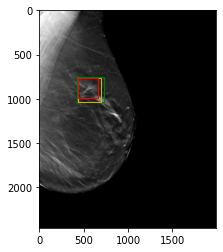

In [ ]:
plt.figure()
plt.imshow(img_data[slice_index, :, :], cmap='gray')
plt.gca().add_patch(Rectangle((GT_x, GT_y), GT_w, GT_h, linewidth=1, edgecolor='g', facecolor='none'))
plt.gca().add_patch(Rectangle((pred_x, pred_y), pred_w, pred_h, linewidth=1, edgecolor='y', facecolor='none'))
plt.gca().add_patch(Rectangle((pred_x, pred_y),224, 224, linewidth=1, edgecolor='r', facecolor='none'))

In [ ]:
to_be_visualized = '/content/gdrive/Shareddrives/DBTdata/model_final_output/gradcam/example.png'
from vgg_cam import main
main(to_be_visualized, output_path)

Done!
